# Vehicle Detection

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from tqdm import tqdm
from skimage.feature import hog
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## HOG feature extraction

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_img = hog(img, orientations=orient,
                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                cells_per_block=(cell_per_block, cell_per_block),
                                visualise=vis, feature_vector=feature_vec)
        return features, hog_img
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
# visualise hog
carimg = cv2.imread('D:\\Repo\\CarND-Vehicle-Detection\\examples\\car.png')
notcarimg = cv2.imread('D:\\Repo\\CarND-Vehicle-Detection\\examples\\notcar.png')

_, car_hog = get_hog_features(carimg[:, :, 0], 9, 8, 2, True, True)
_, notcar_hog = get_hog_features(notcarimg[:, :, 0], 9, 8, 2, True, True)

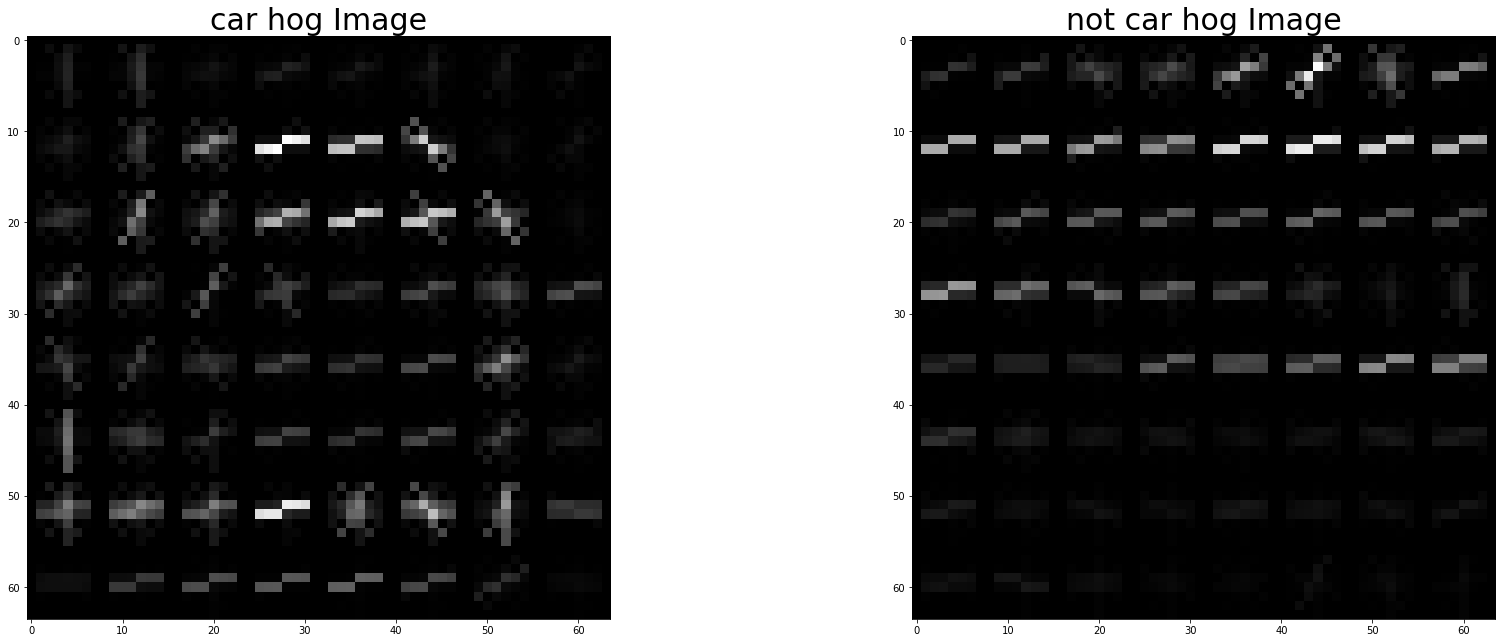

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(car_hog)
ax1.set_title('car hog Image', fontsize=30)
ax2.imshow(notcar_hog)
ax2.set_title('not car hog Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color Transform

In [5]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [6]:
def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

In [7]:
def convert_color(img, conv='BGR2YCrCb'):
    """
    YCbCr seperate the luminance and chrominance components of a scene
    and use less bits for chrominance than luminace.
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

## Construct Feature Vector

In [76]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel, conv='BGR2YCrCb', cells_per_step=1):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    xstart = 700
    img_tosearch = img[ystart:ystop, xstart:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=conv)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64 # make this number the same as the training images
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False) 
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            elif hog_channel == 0:
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            elif hog_channel == 1:
                hog_features = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            elif hog_channel == 2:
                hog_features = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            else:
                raise
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            test_features = X_scaler.transform(np.concatenate([hog_features, spatial_features, hist_features]).reshape(1, -1))       
            confidence = svc.decision_function(test_features)

            if confidence >= 0.5:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox = ((xbox_left+xstart, ytop_draw+ystart), (xbox_left+win_draw+xstart, ytop_draw+win_draw+ystart))
                bbox_list.append(bbox)

    return draw_img, bbox_list          

In [9]:
def extract_features(imgs_path, cspace, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel):
    features = []
    for img_path in tqdm(imgs_path):
        img = cv2.imread(img_path)
        img = img.astype(np.float32)/255
        if cspace != 'BGR':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=False))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=False)
            hog_features = np.ravel(hog_features)
            
        spatial_features = bin_spatial(img, size=spatial_size)
        hist_features = color_hist(img, nbins=hist_bins)
        features.append(np.concatenate([hog_features, spatial_features, hist_features]))
        
    return features

## Pipeline

In [20]:
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (48, 48) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
hist_range = (0, 256)
ystart = 300 # Min and max in y to search in slide_window()
ystop = 656
scale = 1.5
hog_channel = 'ALL'

In [21]:
car_dir = 'D:\\Repo\\CarND-Vehicle-Detection\\vehicles\\vehicles'
cars = []
for directory, _, files in os.walk(car_dir):
    for image in files:
        if image.endswith('png'): cars.append(os.path.join(directory, image))
    
notcar_dir = 'D:\\Repo\\CarND-Vehicle-Detection\\non-vehicles'
notcars = []
for directory, _, files in os.walk(notcar_dir):
    for image in files:
        if image.endswith('png'): notcars.append(os.path.join(directory, image))
            
print('car image size is {}'.format(len(cars)))
print('notcar image size is {}'.format(len(notcars)))

car image size is 8792
notcar image size is 8968


In [22]:
car_features = extract_features(cars, spatial_size=spatial_size, hist_bins=hist_bins,
                        cspace='YCrCb', hog_channel=hog_channel,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)
notcar_features = extract_features(notcars, spatial_size=spatial_size, hist_bins=hist_bins,
                        cspace='YCrCb', hog_channel=hog_channel,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8968/8968 [00:42<00:00, 209.11it/s]


## Training classifier

In [23]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [22]:
# use grid search cross validation
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':['linear'], 'C':[0.01, 0.1, 1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=4, n_jobs=8)
clf.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
print('best classifier: ', clf.best_estimator_)

Test Accuracy of SVC =  0.9899
best classifier:  SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [24]:
svc = svm.LinearSVC(C=0.01)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

46.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9893
My SVC predicts:  [ 0.  0.  1.  1.  1.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  1.  0.]
0.01253 Seconds to predict 10 labels with SVC


## Testing on Image

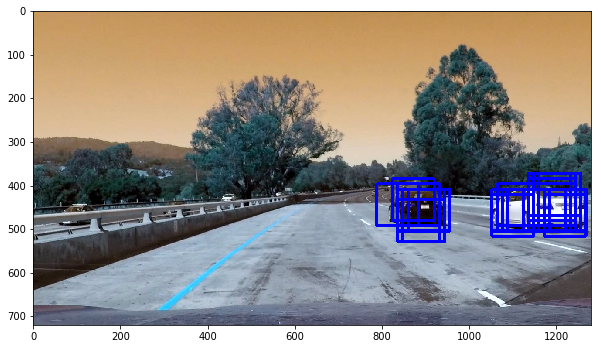

In [25]:
img = cv2.imread('D:\\Repo\\CarND-Vehicle-Detection\\test_images\\test1.jpg')
out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel)
plt.imshow(out_img)

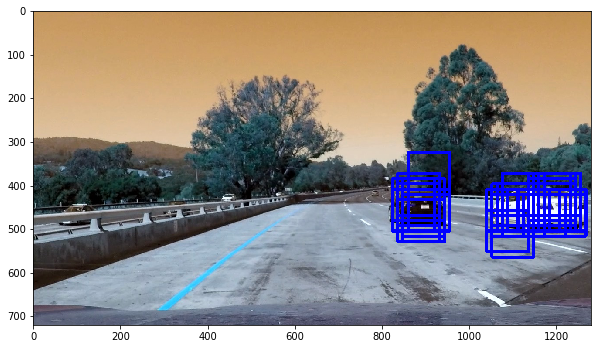

In [16]:
Zimg = cv2.imread('D:\\Repo\\CarND-Vehicle-Detection\\test_images\\test5.jpg')
out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel)
plt.imshow(out_img)

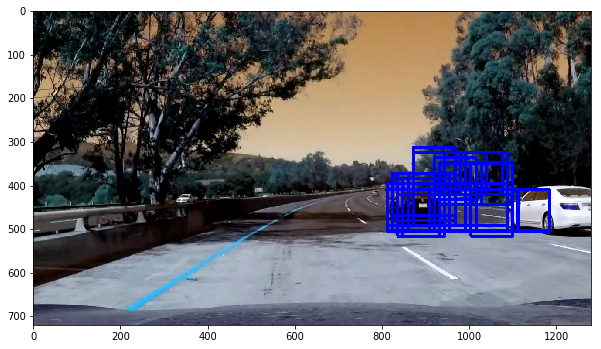

In [17]:
img = cv2.imread('D:\\Repo\\CarND-Vehicle-Detection\\test_images\\test6.jpg')
out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel)
plt.imshow(out_img)

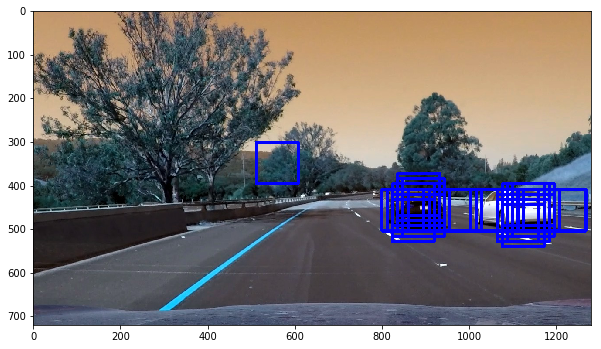

In [18]:
img = cv2.imread('D:\\Repo\\CarND-Vehicle-Detection\\test_images\\test4.jpg')
out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel)
plt.imshow(out_img)

## Implement Heatmap or NMS

In [26]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    output = np.copy(heatmap)
    # Zero out pixels below the threshold
    output[output <= threshold] = 0
    # Return thresholded map
    return output

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

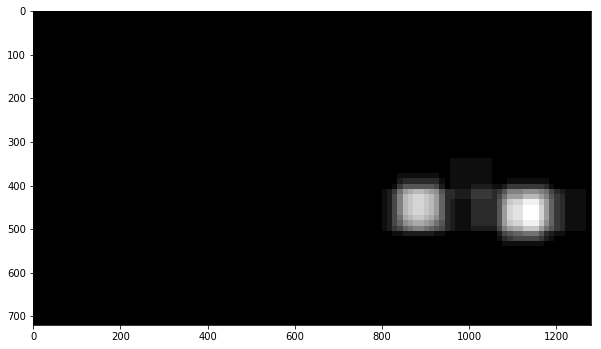

In [20]:
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, bbox_list)
plt.imshow(heatmap)

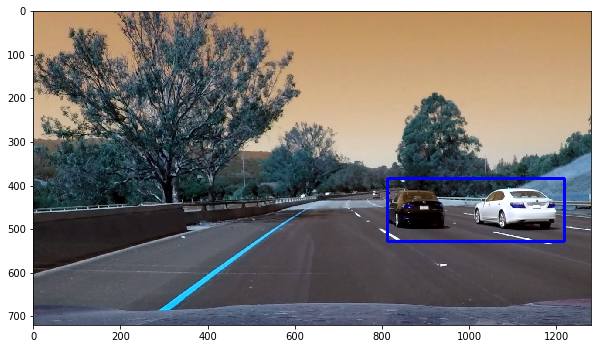

In [21]:
filtered_heatmap = apply_threshold(heatmap, 1)
car_labels = label(filtered_heatmap)
outimg = draw_labeled_bboxes(img, car_labels)
plt.imshow(outimg)

## Use two frame to make prediction

In [22]:
frame1 = cv2.imread('D:\\Repo\\CarND-Vehicle-Detection\\test_images\\test4.jpg')
frame2 = cv2.imread('D:\\Repo\\CarND-Vehicle-Detection\\test_images\\test5.jpg')

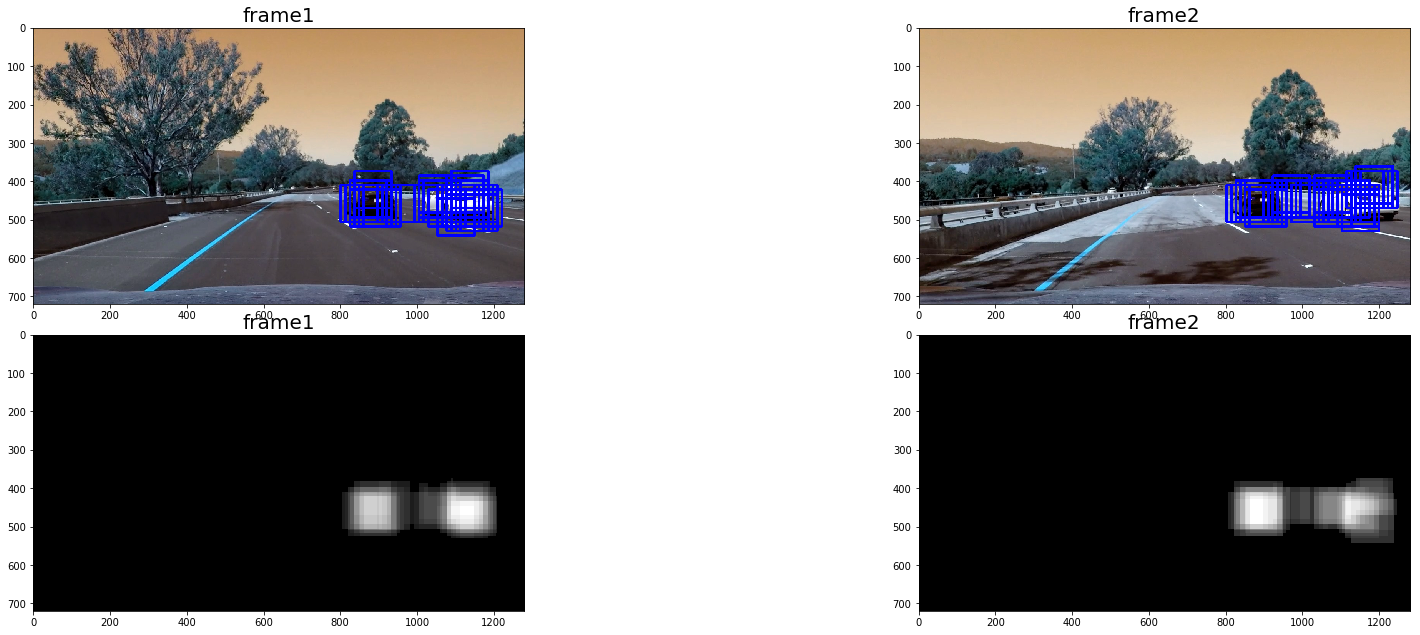

In [23]:
def pipeline(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel):
    out_img, bbox_list = find_cars(img, ystart, ystop, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel, 'RGB2YCrCb', 1)
    out_img, bbox_list2 = find_cars(img, ystart, ystop, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel, 'RGB2YCrCb', 1)    
    return out_img, bbox_list+bbox_list2

orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (48, 48) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
hist_range = (0, 256)
ystart = 350 # Min and max in y to search in slide_window()
ystop = 600
scale = 2
hog_channel = 'ALL'

outimg1, bbox_list1 = pipeline(frame1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel)
outimg2, bbox_list2 = pipeline(frame2, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel)

heatmap1 = np.zeros_like(frame1[:,:,0]).astype(np.float)
heatmap1 = add_heat(heatmap1, bbox_list1)
heatmap1 = apply_threshold(heatmap1, 2)

heatmap2 = np.zeros_like(frame2[:,:,0]).astype(np.float)
heatmap2 = add_heat(heatmap2, bbox_list2)
heatmap2 = apply_threshold(heatmap2, 2)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(outimg1)
ax1.set_title('frame1', fontsize=20)
ax2.imshow(outimg2)
ax2.set_title('frame2', fontsize=20)
ax3.imshow(heatmap1)
ax3.set_title('frame1', fontsize=20)
ax4.imshow(heatmap2)
ax4.set_title('frame2', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

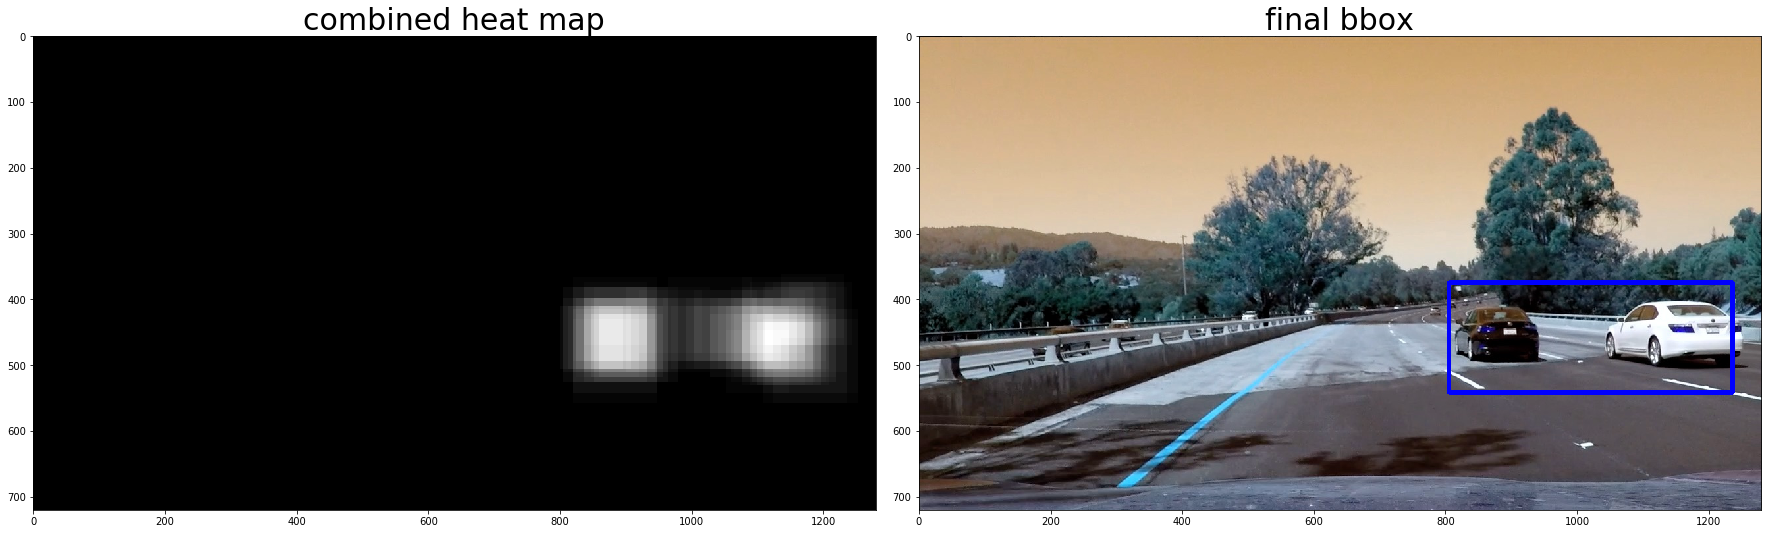

In [24]:
heatmap = np.zeros_like(frame2[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, bbox_list1+bbox_list2)
filtered_heatmap = apply_threshold(heatmap, 3)
car_labels = label(filtered_heatmap)
final_img = draw_labeled_bboxes(frame2, car_labels)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(heatmap)
ax1.set_title('combined heat map', fontsize=30)
ax2.imshow(final_img)
ax2.set_title('final bbox', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Wrapup for processing video

In [59]:
import os
import cv2
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip
from IPython.display import HTML

orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (48, 48) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
hist_range = (0, 256)
ystart = 400 # Min and max in y to search in slide_window()
ystop = 600
scale = 2
hog_channel = 'ALL'

In [68]:
def pipeline(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel):
    out_img, bbox_list = find_cars(img, ystart, ystop, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel, 'RGB2YCrCb', 1)
    out_img, bbox_list2 = find_cars(img, ystart, ystop, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel, 'RGB2YCrCb', 1)
    out_img, bbox_list3 = find_cars(img, ystart, 500, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel, 'RGB2YCrCb', 1)
    total_bbox_list = bbox_list + bbox_list2 + bbox_list3
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, total_bbox_list)
    return out_img, heatmap

In [ ]:
video_path = os.path.join(os.getcwd(), 'project_video.mp4')
cap = cv2.VideoCapture(video_path)

output = 'output_video10.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
out = cv2.VideoWriter(output, fourcc, 20.0, (1280, 720))

# fig, ax = plt.subplots(1, 1)
old_heatmap = 0
old_weight = 0.9
count = 0
while cap.isOpened():
    count += 1
    ret, frame = cap.read()
    if frame is None: break
#     if count <= 525: continue
#     if count >= 725: break
    out_img, heatmap = pipeline(frame, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel)
    heatmap = old_weight*old_heatmap + (1-old_weight)*heatmap
    filtered_heatmap = apply_threshold(heatmap, 1)
    old_heatmap = heatmap
    car_labels = label(filtered_heatmap)
    final_img = draw_labeled_bboxes(frame, car_labels)
    out.write(final_img) # Write out frame to video
    print('{}/1250'.format(count))
#     ax.imshow(final_img)
#     fig.canvas.draw()
    
out.release() 
cap.release()

1/1250
2/1250
3/1250
4/1250
5/1250
6/1250
7/1250
8/1250
9/1250
10/1250
11/1250
12/1250
13/1250
14/1250
15/1250
16/1250
17/1250
18/1250
19/1250
20/1250
21/1250
22/1250
23/1250
24/1250
25/1250
26/1250
27/1250
28/1250
29/1250
30/1250
31/1250
32/1250
33/1250
34/1250
35/1250
36/1250
37/1250
38/1250
39/1250
40/1250
41/1250
42/1250
43/1250
44/1250
45/1250
46/1250
47/1250
48/1250
49/1250
50/1250
51/1250
52/1250
53/1250
54/1250
55/1250
56/1250
57/1250
58/1250
59/1250
60/1250
61/1250
62/1250
63/1250
64/1250
65/1250
66/1250
67/1250
68/1250
69/1250
70/1250
71/1250
72/1250
73/1250
74/1250
75/1250
76/1250
77/1250
78/1250
79/1250
80/1250
81/1250
82/1250
83/1250
84/1250
85/1250
86/1250
87/1250
88/1250
89/1250
90/1250
91/1250
92/1250
93/1250
94/1250
95/1250
96/1250
97/1250
98/1250
99/1250
100/1250
101/1250
102/1250
103/1250
104/1250
105/1250
106/1250
107/1250
108/1250
109/1250
110/1250
111/1250
112/1250
113/1250
114/1250
115/1250
116/1250
117/1250
118/1250
119/1250
120/1250
121/1250
122/1250
123/1250
1

923/1250
924/1250
925/1250
926/1250
927/1250
928/1250
929/1250
930/1250
931/1250
932/1250
933/1250
934/1250
935/1250
936/1250
937/1250
938/1250
939/1250
940/1250
941/1250
942/1250
943/1250
944/1250
945/1250
946/1250
947/1250
948/1250
949/1250
950/1250
951/1250
952/1250
953/1250
954/1250
955/1250
956/1250
957/1250
958/1250
959/1250
960/1250
961/1250
962/1250
963/1250
964/1250
965/1250
966/1250
967/1250
968/1250
969/1250
970/1250
971/1250
972/1250
973/1250
974/1250
975/1250
976/1250
977/1250
978/1250
979/1250
980/1250
981/1250
982/1250
983/1250
984/1250
985/1250
986/1250
987/1250
988/1250
989/1250
990/1250
991/1250
992/1250
993/1250
994/1250
995/1250
996/1250
997/1250
998/1250
999/1250
1000/1250
1001/1250
1002/1250
1003/1250
1004/1250
1005/1250
1006/1250
1007/1250
1008/1250
1009/1250
1010/1250
1011/1250
1012/1250
1013/1250
1014/1250
1015/1250
1016/1250
1017/1250
1018/1250
1019/1250
1020/1250
1021/1250
1022/1250
1023/1250
1024/1250
1025/1250
1026/1250
1027/1250
1028/1250
1029/1250
1030/12